In this notebook, we will look at different types of noises that are introduced into the camera while capturing an image. We will understand the theory behind them and model them on an image. Later we will look at ways to remove these noise using post processing techniques.

This notebook is greatly inspired and adapted from : http://kmdouglass.github.io/posts/modeling-noise-for-image-simulations/ 

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy as sp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sklearn

## **Image Noise**

Any unwanted modification of the signal during capture, conversion, transfer and storage is called as noise. Noise is a system is unavoidable as no component is ideal and have some defects or limitations that introduce noise. 

There are two types of noises:
1. Photon shot noise (Scene dependent)
2. Readout or Read noise (Scene independent)


## **Modelling the photon shot noise**

Ideal camera assumes that all the pixel in the sensor recieve the same number of photons, hence the brightness of the entire scene is constant. However, due to the random nature of the photons, each sensor recieves different amounts. 

The brightness of a pixel is directly dependent on the number of photons hitting the sensor ( more photons hit the silicon, more electrons will be ejected and higher will tbe voltage for that pixel).

Rough estimate of the number of photons hitting each pixel is computed using a Poisson distribution. For large value of the mean, Poisson ditribution apporaches a Gaussian distribution.

$f(k;\lambda) = \frac{\lambda ^{k}e^{-\lambda}}{\lambda !}$

For simplicity sake, we will assume a camera sensor of size 256x256 pixels and the mean incident photon flux to be 500 photons/pixel.

Text(0.5, 1.0, 'Poisson distribution(Mean=100)')

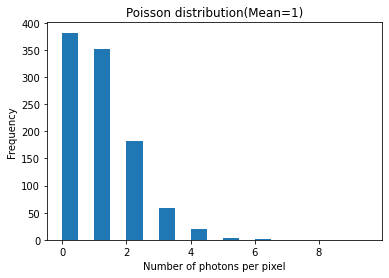

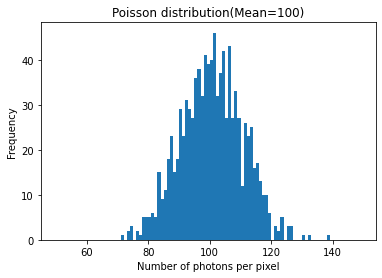

In [68]:
# Poisson distribution
p = np.random.poisson(1,1000)
plt.hist(p, bins = np.arange(0,10,0.5))
plt.xlabel("Number of photons per pixel")
plt.ylabel("Frequency")
plt.title("Poisson distribution(Mean=1)")

# as you increase the mean, the distribution apporaches a Gaussian
p1 = np.random.poisson(100,1000)
plt.figure()
plt.hist(p1, bins = np.arange(50,150,1))
plt.xlabel("Number of photons per pixel")
plt.ylabel("Frequency")
plt.title("Poisson distribution(Mean=100)")

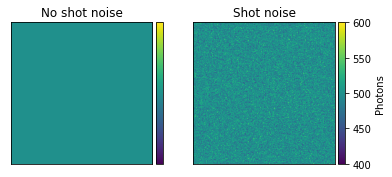

In [8]:
# noiseless image

num_photons = 500
img_size = 256

mu_p = num_photons * np.ones((256,256)) # assuming every pixel gets the same number of photons.

# with noise
shot_noise = np.random.poisson(num_photons,(256,256))  #generate a matrix of size=Image size sampled from Poisson distribution with mean = 500
fig, (ax0, ax1) = plt.subplots(ncols=2)
img0 = ax0.imshow(mu_p, vmin=400, vmax=600)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('No shot noise')
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = plt.colorbar(img0, cax=cax)
cb0.set_ticks([])

img1 = ax1.imshow(shot_noise, vmin=400, vmax=600)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Shot noise')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(img1, cax=cax)
cb1.set_label('Photons')

plt.show()

Text(0.5, 1.0, 'Noisy')

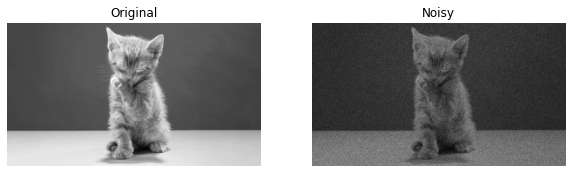

In [131]:
# example of shot noise on an actual image
img = plt.imread("/content/drive/MyDrive/hw6_images/cat.jpg")
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# create a noisy image - each pixel value acts as incoming photon count
img_noisy = np.random.poisson(gray_img/(0.05*255))
#img_noisy = img_noisy/np.max(img_noisy)*255
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(gray_img,cmap='gray')
plt.axis('off')
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(img_noisy,cmap='gray')
plt.axis('off')
plt.title("Noisy")

Shot noise is usually observed in images taken under low light conditions. To remove shot noise, we just increase the exposure time to let enough photons enter the sensor.

## **Modelling the Dark Noise**

Dark noise refers to the noise in the pixels when there is no light on the camera. Typically there are two sources of dark noise: Read noise and Dark current. 

Read noise is generated when we convert the number of electrons to voltage. This noise can be modelled as a Gaussian distribution. 

Dark current is very low and is overpowered by the read noise, hence we can ignore it. 

Read noise depends on the camera specifications. We will use the Sony IMX264 CMOS chip, the FLIR Chamleon 3 camera.
1. Quantum efficieny = 0.69
2. Light wavelength = 525 nm
3. Temporal dark noise	2.29 e-
4. Analog-to-digital converter (ADC)	12-bit
5. Sensitivity	5.88 ADU / e-


In [70]:
q_eff = 0.69
n_electrons = np.round(q_eff*shot_noise)
dark_noise = 2.29
sensitivity = 5.88
electrons_out = np.round(np.random.normal(scale=dark_noise, size=n_electrons.shape) + n_electrons)

Now we need to convert each pixel into ADU(Analog to Digital Units) voltage. This is done by multiplying the electrons with the sensistivity. This number is discritized and bounded by the ADC bit depth i.e $2^{12} - 1$ for this camera.

The link gives a great explaination of read noise and dark noise and how to measure read noise in images:
http://astro.physics.uiowa.edu/~kaaret/2015f_a4850/Lab03_noise.html 

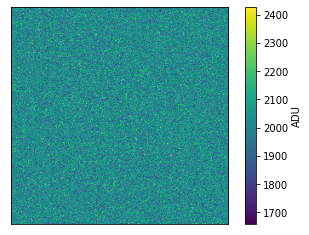

In [73]:
ADU = (sensitivity * electrons_out).astype(int)
max_ADU = np.int(2**12 -1)
ADU[ADU>max_ADU] = max_ADU    # saturation of pixel voltage
fig, ax = plt.subplots()
img1 = ax.imshow(ADU)
ax.set_xticks([])
ax.set_yticks([])

cb = plt.colorbar(img1)
cb.set_label('ADU')

plt.show()

Text(0.5, 1.0, 'Noisy')

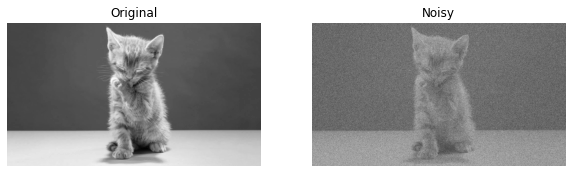

In [142]:
# read noise on image
'''
Since the images are already digitized, we can model read noise by using an additive Gaussian noise to the image.
'''

noise = np.random.normal(scale=dark_noise,size=gray_img.shape)
noisy_img = gray_img/255 + 0.1*noise

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(gray_img,cmap='gray')
plt.axis('off')
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(noisy_img,cmap='gray')
plt.axis('off')
plt.title("Noisy")

Read noise can be minimised by using a Gaussian or a Median filter

Text(0.5, 1.0, 'Filtered')

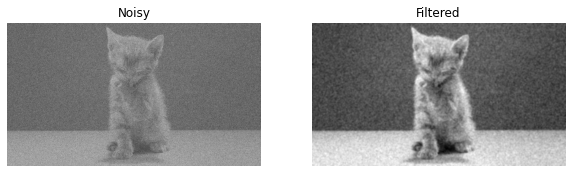

In [148]:
filt_img = cv2.GaussianBlur(noisy_img,(11,11),dark_noise)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(noisy_img,cmap='gray')
plt.axis('off')
plt.title("Noisy")
plt.subplot(1,2,2)
plt.imshow(filt_img,cmap='gray')
plt.axis('off')
plt.title("Filtered")

## **Modelling Salt and Pepper Noise**

Salt and Pepper noise is a type of impulsive noise sometimes observed in the monochrome image. It is called an impulse noise because it affects only certain pixels of the image and not all of them. 

Salt noise refers to certain pixels being turned to max value (255). This noise is caused generally due to quantization error. 

Pepper noise refers to certain pixels in the sensor being dead i.e no light is stored in them. Hence those pixel values will be 0. 


Text(0.5, 1.0, 'Noisy')

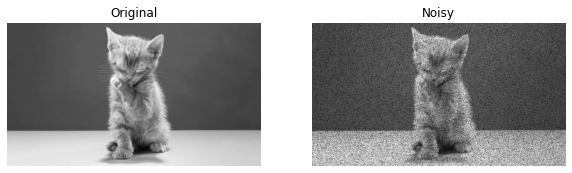

In [141]:
#adding salt and pepper noise

def add_salt_and_pepper(img, prob):
    '''
    This function adds a salt and pepper noise to image. The image has to be Grayscale
    '''
    rnd = np.random.rand(img.shape[0], img.shape[1])
    noisy = img.copy()
    noisy[rnd < prob] = 0
    noisy[rnd > 1 - prob] = 1
    return noisy

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sp_img = add_salt_and_pepper(gray_img,0.1)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(gray_img,cmap='gray')
plt.axis('off')
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(sp_img,cmap='gray')
plt.axis('off')
plt.title("Noisy")

Salt and Pepper Noise can be easily minimised by using Median filter. A median filter selects the median intensity value from a window of size NxN centered around that pixel.

Since salt and pepper noises are two extremities of the intensity spectrum, when computing the median, they are pushed to the start or end of the sequence and are never picked as the median.

Text(0.5, 1.0, 'Filtered')

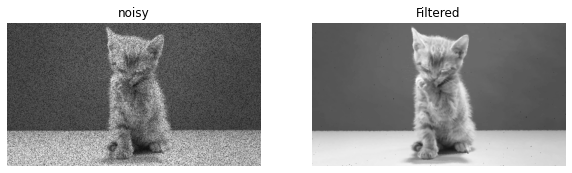

In [140]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(sp_img,cmap='gray')
plt.axis('off')
plt.title("noisy")
filt_img = cv2.medianBlur(sp_img,5)
plt.subplot(1,2,2)
plt.imshow(filt_img,cmap='gray')
plt.axis('off')
plt.title("Filtered")